In [1]:
from src import incremental_transformer as it
from src import shift_comparison_predictor as shift_pred
from src import simple_comparison_predictor as simple_pred
import pandas as pd
from src import normalization as norm
import numpy as np
%matplotlib inline

In [14]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 12, 9

In [3]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

In [4]:
mpl.rcParams['font.sans-serif'].insert(0, 'Liberation Sans')
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
mpl.rcParams['font.family'] = 'sans-serif'

In [5]:
import seaborn as sns
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': 'white',
 'axes.facecolor': '#EAEAF2',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.linewidth': 0,
 'figure.facecolor': 'white',
 'font.family': 'sans-serif',
 'font.sans-serif': ['Arial',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': 'white',
 'grid.linestyle': '-',
 'image.cmap': 'Greys',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': 'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.major.size': 0,
 'xtick.minor.size': 0,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.major.size': 0,
 'ytick.minor.size': 0}

In [6]:
def rmse(prediction, target):
    return np.sqrt(((prediction - target) ** 2).mean())

In [7]:
def mape(prediction, target):
    return np.mean(np.abs((target - prediction) / target)) * 100

In [8]:
def smape(prediction, target):
    return np.mean(np.abs(target - prediction) / np.abs(target + prediction)) * 200

In [9]:
def mae(prediction, target):
    return np.mean(np.abs(target - prediction)) * 100

In [10]:
def mdae(prediction, target):
    return np.median(np.abs(target - prediction)) * 100

In [11]:
filename = "~/shared/energo_data/data/01_zilina_suma.csv"
data = pd.DataFrame.from_csv(filename, index_col=[0,1])

In [12]:
# sample_data = data.SUM_of_MNOZSTVO[0:(96*14)]
sample_data = data.SUM_of_MNOZSTVO

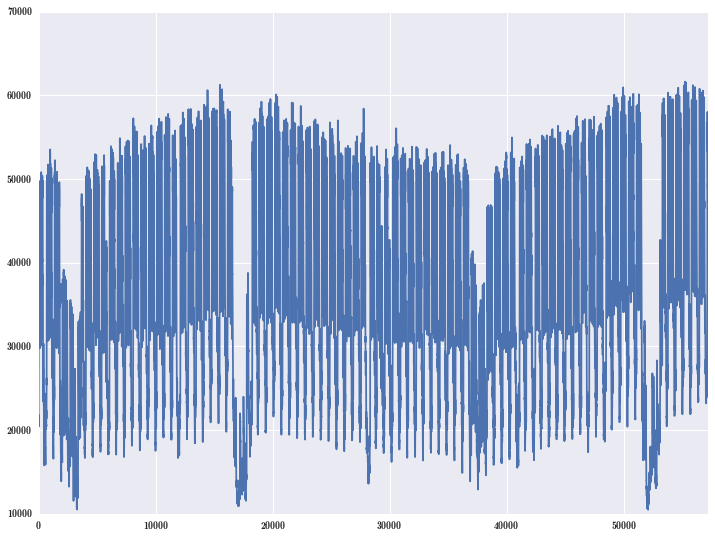

In [15]:
data.reset_index().SUM_of_MNOZSTVO.plot()

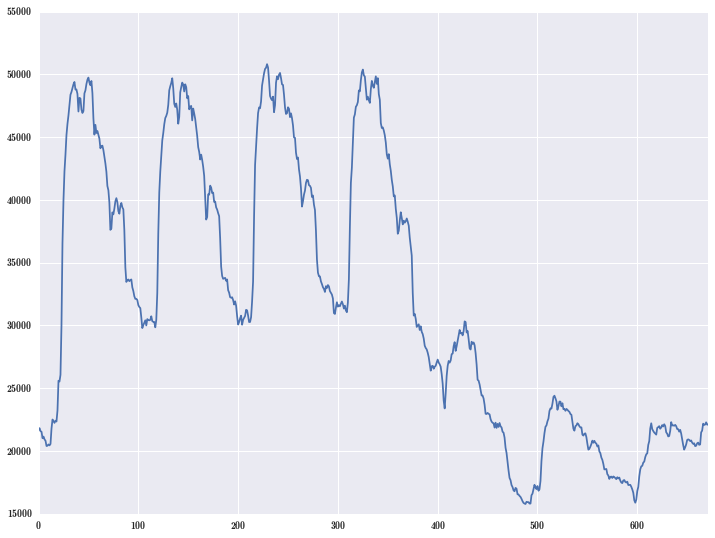

In [16]:
subsample = data.SUM_of_MNOZSTVO[:(96*7)].reset_index().SUM_of_MNOZSTVO
subsample.plot()

# Len taky pokus a definicia funkcii na pracu s PAA

In [15]:
def paa(series, coefficient):
    """
    series - data na transformaciu
    coefficient - pocet za sebou nasledujucich hodnot, ktore sa maju spojit    
    """
    sub_series = series[0:((len(series) / coefficient) * coefficient)] # skratenie na nasobok koeficientu
    composite_list = [sub_series[x:x+coefficient] for x in range(0, len(sub_series),coefficient)] # rozsekanie na kusky dlzku koeficientu
    result = [x.mean() for x in composite_list]
    return sub_series, pd.Series(result) # vracia aj skratenu hodnotu a aj paa reprezentaciu

In [16]:
def un_paa(series, coefficient):
    """
    series - data na transformaciu
    coefficient - pocet za sebou nasledujucich hodnot, ktore sa maju vytvorit    
    """
    array = []
    for x in series:
        array += ([x] * coefficient)
    return pd.Series(array)

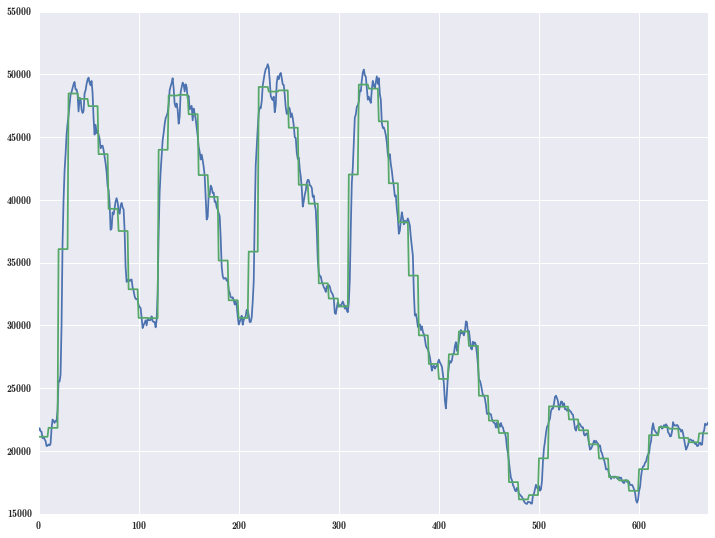

In [37]:
coefficient = 10
subseries, result = paa(subsample, coefficient)
reconstructed = un_paa(result, coefficient)
subseries.plot()
reconstructed.plot()

In [38]:
rmses = []
coefficients = []
sizes = []

for coefficient in xrange(1, 96):
    subseries, result = paa(sample_data, coefficient)
    reconstructed = un_paa(result, coefficient)
    rmses.append(rmse(np.array(reconstructed), np.array(subseries)))
    sizes.append(int(len(sample_data) / coefficient))
    coefficients.append(coefficient)

In [40]:
paa_results2 = pd.DataFrame()
paa_results2['Transformed data size'] = sizes
# paa_results['coefficient'] = coefficients
paa_results2['RMSE'] = rmses
paa_results2.index = coefficients

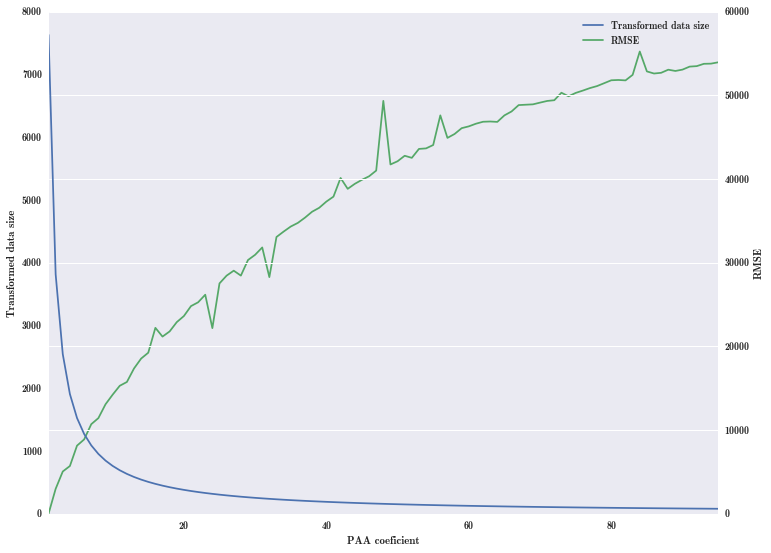

In [45]:
ax = paa_results2.plot(secondary_y=['Transformed data size'], mark_right=False)
ax.set_ylabel('Transformed data size')
ax.set_xlabel('PAA coeficient')
ax.right_ax.set_ylabel('RMSE')

# Pokusy a definicia funkcii na pracu s mojou reprezentaciou

In [24]:
normalization = norm.ZNormalization()
# Natrenovanie koeficientov normalizacie na prvom tyzdni dat
normalization.train_coefficients(data.SUM_of_MNOZSTVO[0:(96*7)])

In [25]:
trans = it.IncrementalTransformer(96, 96, 2.0, normalization=normalization)
symbols = trans.transform(subsample)

In [26]:
result = trans.reconstruct(symbols)

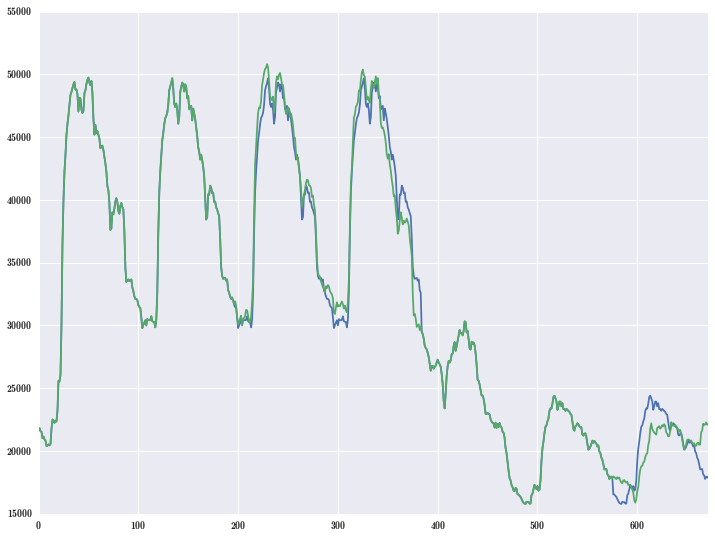

In [27]:
pd.Series(result).plot()
subsample.plot()

# zavyslost od mnozstva spracovanych dat

In [17]:
coefficient = 10

step = 96 * 7

isc_rmse = []
isc_size = []
paa_rmse = []
paa_size = []
data_sizes = []

normalization = norm.ZNormalization()
# Natrenovanie koeficientov normalizacie na prvom tyzdni dat
normalization.train_coefficients(data.SUM_of_MNOZSTVO[0:(96*7)])

In [18]:
for data_size in xrange(1,int(len(sample_data)/step)):
    subsample = sample_data[0:(data_size * step)]
    data_sizes.append(data_size * step)
    
    trans = it.IncrementalTransformer(96, 96, 2.6, normalization=normalization)
    symbols = trans.transform(subsample)
    isc_result = trans.reconstruct(symbols)
    
    isc_rmse.append(rmse(isc_result, subsample[0:(len(isc_result))]))
    isc_size.append((len(symbols) * 3) + (trans.distance_matrix.size() * 96))
    
    paa_subseries, paa_result = paa(subsample, coefficient)
    paa_reconstructed = un_paa(paa_result, coefficient)
    paa_rmse.append(rmse(np.array(paa_reconstructed), np.array(paa_subseries)))
    paa_size.append(int(len(subsample) / coefficient))

In [24]:
all_results = pd.DataFrame()
all_results['PAA data size'] = paa_size
all_results['PAA RMSE'] = paa_rmse
all_results['ISC data size'] = isc_size
all_results['ISC RMSE'] = isc_rmse
all_results['Amount of processed data'] = data_sizes

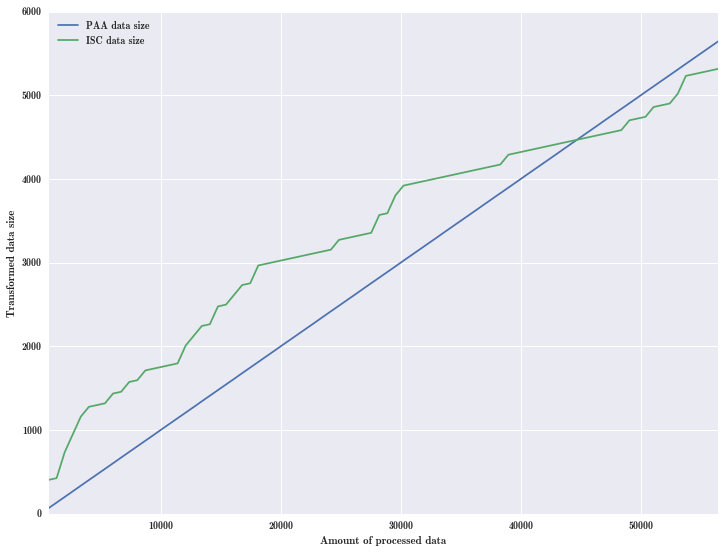

In [25]:
ax = all_results.plot(x='Amount of processed data', y=['PAA data size', 'ISC data size'])
ax.set_ylabel('Transformed data size')
ax.set_xlabel('Amount of processed data')

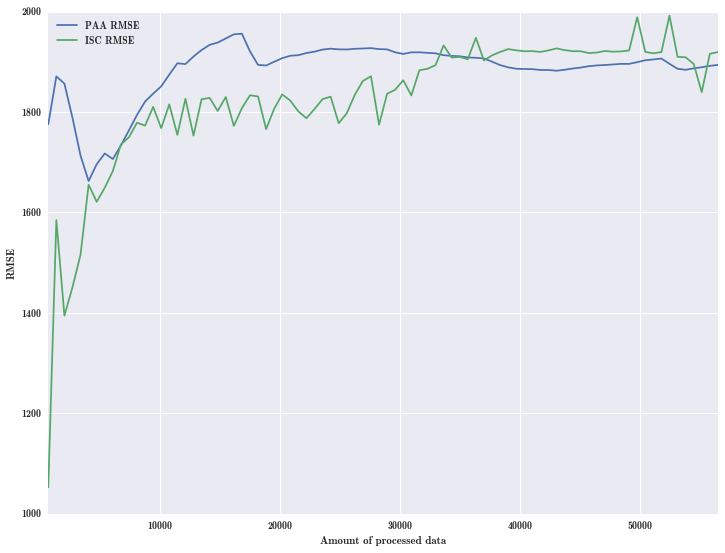

In [26]:
ax = all_results.plot(x='Amount of processed data', y=['PAA RMSE', 'ISC RMSE'])
ax.set_ylabel('RMSE')
ax.set_xlabel('Amount of processed data')